# LSTM
Cell Line A549. LSTM 133. Coding 3-4K. 

Acc 74%, Prec 72%, Recall 66%, F1 69%.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-01-17 16:43:39.649796
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=3000
MAXLEN=4000   

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
CELL_LINE = 0
print('Use only this cell line',all_cell_lines[CELL_LINE])

Use only this cell line A549


## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        overall_count = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line+1]
                    if rci_str != "nan":
                        # Convert string nan to float(nan)
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
                        overall_sum += rci_val
                        overall_count += 1
        overall_mean = overall_sum / overall_count
        print('Number of RCI values',overall_count)
        print('Mean RCI value',overall_mean)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [7]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Num labels:',len(labels))
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num sequences:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2023-01-17 16:44:06.056266
Load RCI values...
Number of RCI values 13000
Mean RCI value -0.036765961332307674
Num RCI: 13000
Example RCI: [('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]
Load genes...
2023-01-17 16:44:06.853997
Load sequence...
2023-01-17 16:44:18.848377
Num IDs: 6935
Example IDs: [('ENSG00000197530', 'ENST00000505820.7'), ('ENSG00000149527', 'ENST00000278878.6'), ('ENSG00000171680', 'ENST00000535355.6'), ('ENSG00000171680', 'ENST00000537245.6')]
Count 2965 ones out of 6935 labels.
Num labels: 6935
Example labels: [0, 0, 0, 0]
Num sequences: 6935
Example sequence: [205, 49, 193, 4, 15, 58, 232, 160, 126, 248, 222, 117, 212, 78, 53, 211, 73, 34, 136, 30, 117, 209, 67, 11, 42, 166, 152, 95, 121, 227, 139, 44, 175, 185, 228, 143, 58, 232, 159, 121, 228, 143, 58, 232, 159, 124, 239, 186, 230, 152, 95, 121, 225, 132, 16, 62, 246, 213, 83, 74, 37, 147, 75, 43, 169, 163, 139, 41, 163, 139, 42, 165, 148, 79, 57, 227, 139, 44, 175, 186,

## Model

In [8]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=False)   
    rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=True) )
    dens_layer = TimeDistributed(Dense(DCELLS))
    flat_layer = Flatten()
    drop_layer = Dropout(0.5) # this model will rely on specific time points not patterns
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    #rnn.add(mask_layer)
    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(dens_layer)
    rnn.add(flat_layer)
    rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [9]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2023-01-17 16:44:18.897560
COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3997, 4)           1028      
                                                                 
 bidirectional (Bidirectiona  (None, 3997, 64)         9472      
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 3997, 16)         1040      
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 63952)             0         
                                                                 
 dropout (Dropout)           (None, 63952)             0         
                                                                 
 dense_1 (Dense)     

## Training

In [10]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = threshold
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2023-01-17 16:44:22.223612
2023-01-17 16:44:22.224175
splitting
Fold 1
Training example
[167 155 106 ...   0   0   0]
Train sizes (5543, 3997) (5543, 1)
Valid sizes (1392, 3997) (1392, 1)
Train set ones/size 2391 / 5543
Valid set ones/size 574 / 1392
BUILD MODEL
COMPILE
FIT
2023-01-17 16:44:24.426573
Epoch 1/3
174/174 [==============================] - 46s 217ms/step - loss: 0.5554 - accuracy: 0.7110 - val_loss: 0.5381 - val_accuracy: 0.7277
Epoch 2/3
174/174 [==============================] - 38s 221ms/step - loss: 0.4933 - accuracy: 0.7714 - val_loss: 0.5351 - val_accuracy: 0.7292
Epoch 3/3
174/174 [==============================] - 37s 215ms/step - loss: 0.4574 - accuracy: 0.7963 - val_loss: 0.5436 - val_accuracy: 0.7385


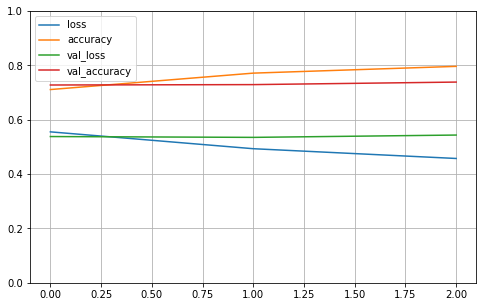

Compute valiation accuracy
2023-01-17 16:46:50.240437
Range of scores: 0.004107717 to 0.9911265
Predicted zeros and ones 854 538
Accuracy: 73.85% Precision: 69.52% Recall: 65.16% F1: 67.27%
2023-01-17 16:46:56.101785
Fold 2
Training example
[167 155 106 ...   0   0   0]
Train sizes (5522, 3997) (5522, 1)
Valid sizes (1413, 3997) (1413, 1)
Train set ones/size 2375 / 5522
Valid set ones/size 590 / 1413
BUILD MODEL
COMPILE
FIT
2023-01-17 16:46:58.209357
Epoch 1/3
173/173 [==============================] - 42s 218ms/step - loss: 0.5579 - accuracy: 0.7213 - val_loss: 0.4998 - val_accuracy: 0.7622
Epoch 2/3
173/173 [==============================] - 37s 213ms/step - loss: 0.5010 - accuracy: 0.7644 - val_loss: 0.5084 - val_accuracy: 0.7374
Epoch 3/3
173/173 [==============================] - 37s 214ms/step - loss: 0.4581 - accuracy: 0.7923 - val_loss: 0.5165 - val_accuracy: 0.7509


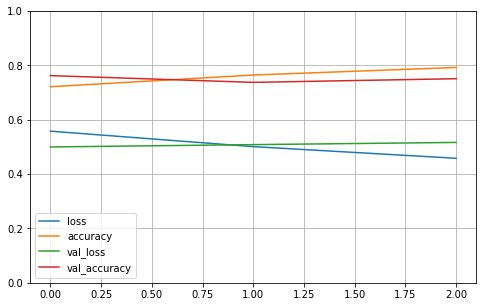

Compute valiation accuracy
2023-01-17 16:49:24.435949
Range of scores: 0.0062039667 to 0.9660822
Predicted zeros and ones 821 592
Accuracy: 75.09% Precision: 70.10% Recall: 70.34% F1: 70.22%
2023-01-17 16:49:30.714481
Fold 3
Training example
[167 155 106 ...   0   0   0]
Train sizes (5525, 3997) (5525, 1)
Valid sizes (1410, 3997) (1410, 1)
Train set ones/size 2355 / 5525
Valid set ones/size 610 / 1410
BUILD MODEL
COMPILE
FIT
2023-01-17 16:49:32.785572
Epoch 1/3
173/173 [==============================] - 41s 219ms/step - loss: 0.5424 - accuracy: 0.7204 - val_loss: 0.5324 - val_accuracy: 0.7674
Epoch 2/3
173/173 [==============================] - 37s 212ms/step - loss: 0.4908 - accuracy: 0.7725 - val_loss: 0.5293 - val_accuracy: 0.7752
Epoch 3/3
173/173 [==============================] - 36s 210ms/step - loss: 0.4510 - accuracy: 0.7895 - val_loss: 0.5552 - val_accuracy: 0.7589


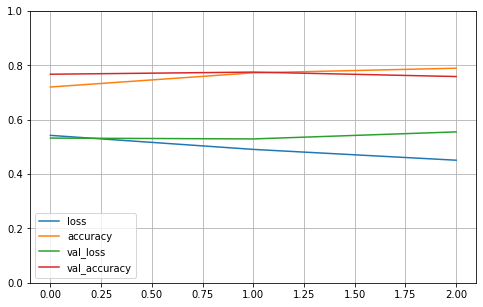

Compute valiation accuracy
2023-01-17 16:51:26.895021
Range of scores: 0.006177031 to 0.9746386
Predicted zeros and ones 828 582
Accuracy: 75.89% Precision: 73.20% Recall: 69.84% F1: 71.48%
2023-01-17 16:51:32.687897
Fold 4
Training example
[167 155 106 ...   0   0   0]
Train sizes (5528, 3997) (5528, 1)
Valid sizes (1407, 3997) (1407, 1)
Train set ones/size 2370 / 5528
Valid set ones/size 595 / 1407
BUILD MODEL
COMPILE
FIT
2023-01-17 16:51:34.779909
Epoch 1/3
173/173 [==============================] - 42s 221ms/step - loss: 0.5522 - accuracy: 0.7229 - val_loss: 0.5243 - val_accuracy: 0.7448
Epoch 2/3
173/173 [==============================] - 37s 212ms/step - loss: 0.4950 - accuracy: 0.7713 - val_loss: 0.5367 - val_accuracy: 0.7242
Epoch 3/3
173/173 [==============================] - 36s 211ms/step - loss: 0.4603 - accuracy: 0.7885 - val_loss: 0.5302 - val_accuracy: 0.7406


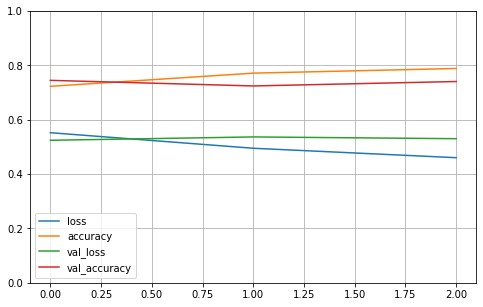

Compute valiation accuracy
2023-01-17 16:53:30.041504
Range of scores: 0.010574619 to 0.97385716
Predicted zeros and ones 845 562
Accuracy: 74.06% Precision: 70.46% Recall: 66.55% F1: 68.45%
2023-01-17 16:53:34.617121
Fold 5
Training example
[ 95 123 235 ...   0   0   0]
Train sizes (5622, 3997) (5622, 1)
Valid sizes (1313, 3997) (1313, 1)
Train set ones/size 2369 / 5622
Valid set ones/size 596 / 1313
BUILD MODEL
COMPILE
FIT
2023-01-17 16:53:36.699778
Epoch 1/3
176/176 [==============================] - 41s 214ms/step - loss: 0.5516 - accuracy: 0.7223 - val_loss: 0.5118 - val_accuracy: 0.7471
Epoch 2/3
176/176 [==============================] - 37s 210ms/step - loss: 0.4889 - accuracy: 0.7773 - val_loss: 0.5499 - val_accuracy: 0.7190
Epoch 3/3
176/176 [==============================] - 37s 209ms/step - loss: 0.4432 - accuracy: 0.8024 - val_loss: 0.5667 - val_accuracy: 0.7228


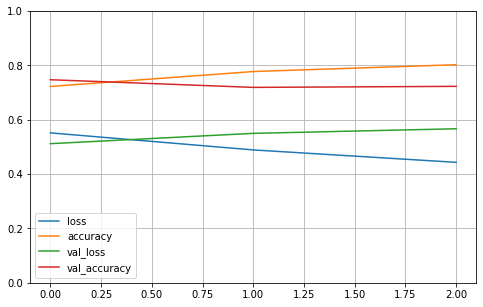

Compute valiation accuracy
2023-01-17 16:55:31.286479
Range of scores: 0.0031156526 to 0.9790659
Predicted zeros and ones 849 464
Accuracy: 72.28% Precision: 75.00% Recall: 58.39% F1: 65.66%
2023-01-17 16:55:35.558816

Cross validation 5 folds 3 epochs
 accuracy mean 74.23% +/- 1.22
 precision mean 71.66% +/- 2.10
 recall mean 66.06% +/- 4.30
 F1 mean 68.62% +/- 2.07
2023-01-17 16:55:35.561993


In [11]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())